In [1]:
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import time
from scipy import optimize
%matplotlib inline

In [2]:
np.random.seed(50)

In [3]:
def f_(x, P, c_t):
    #get projection of x
    x_ = euclidean_proj_simplex(x)
    y = P @ x_
    if (np.min(y) <= 0):
        return np.inf
    return c_t @ x_ + np.sum(y * np.log(y) / np.log(2))

def grad_f_(x, P, c_t):
    #get projection of x
    x_ = euclidean_proj_simplex(x)
    y = P @ x_
    if (np.min(y) <= 0):
        raise ValueError
    grad = c_t.copy()
    tmp = []
    for i in range(m):
        tmp.append(P[i] * (np.log(P[i] @ x_) + 1) / np.log(2))
    tmp_sum = np.sum(np.array(tmp), axis=0)
    return grad + tmp_sum

def gess_f_(x, P, c_t):
    #get projection of x
    x_ = euclidean_proj_simplex(x)
    y = P @ x_
    if (np.min(y) <= 0):
        raise ValueError
    gess = []
    for i in range(m):
        tmp = np.atleast_2d(P[i]).T @ np.atleast_2d(P[i])
        gess.append(tmp / (y[i] * np.log(2)))
    return np.sum(np.array(gess), axis=0)

In [4]:
def euclidean_proj_simplex(v, s=1):
    n, = v.shape  
    if v.sum() == s and np.alltrue(v >= 0):
        return v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    theta = (cssv[rho] - s) / (rho + 1.0)
    w = (v - theta).clip(min=0)
    return w

In [5]:
class StoppingCriteria:
    def __init__(self, max_iterations=np.inf, min_grad_norm=0):
        self.max_iterations = max_iterations
        self.min_grad_norm = min_grad_norm
    
    def __call__(self, state):
        cur_iterations = state['iterations']
        cur_grad_norm = np.linalg.norm(state['cur_grad'], ord=2)
        dif_x = np.linalg.norm(state['x'] - state['prev_x'], ord=2)
        return (cur_iterations >= self.max_iterations or 
                cur_grad_norm <= self.min_grad_norm or dif_x <= self.min_grad_norm)
    
class StoppingCriteriaNewton:
    def __init__(self, max_iterations=np.inf, tolerance=1e-6, min_grad_norm=0):
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.min_grad_norm = min_grad_norm
    
    def __call__(self, state):
        cur_iterations = state['iterations']
        dif_x = np.linalg.norm(state['x'] - state['prev_x'], ord=2)
        cur_decrement = state['cur_grad'].T @ state['cur_gess_inv'] @ state['cur_grad']
        return (cur_iterations >= self.max_iterations or 
                cur_decrement/2 <= self.tolerance or dif_x <= self.min_grad_norm)

In [6]:
class StepSearchFastestTernary:
    def __init__(self, precision):
        self.precision = precision
        self.left = 0
        self.right = None
        
    def __update_starting_points(self, state, init_kpower=-2):
        k_power = init_kpower
        f = state['f']
        x = state['x']
        grad_f = state['cur_grad']
        dx = - grad_f
        while f(x + 2**k_power * dx) > f(x + 2**(k_power + 1) * dx):
            k_power += 1
        if k_power == init_kpower:
            self.left = 0
        else:
            self.left = 2**(k_power - 1)
        self.right = 2**(k_power + 1)
            
            
    def __call__(self, state):
        f = state['f']
        x = state['x']
        cur_grad = state['cur_grad']
        dx = -cur_grad
        
        self.__update_starting_points(state) # update self.left and self.right
        
        right = self.right
        left = self.left
        
        while True:
            if abs(right - left) < self.precision:
                return (left + right)/2

            left_div = left + (right - left)/3
            right_div = right - (right - left)/3

            f_left = f(x + left_div * dx)
            f_right = f(x + right_div * dx)
            
            if f_left == np.inf:
                right = right_div
            else:
                if f_left < f_right:
                    right = right_div
                else:
                    left = left_div
        

In [7]:
class StepSearchBacktracking:
    def __init__(self, alpha=0.01, beta=0.7):
        self.alpha = alpha
        self.beta = beta
            
    def __call__(self, state):
        t = 1
        f = state['f']
        grad_f = state['grad_f']
        x = state['x']
        dx = -state['cur_grad']
        grad_proj = euclidean_proj_simplex(grad_f(x))
        while f(x + t * dx) > f(x) + self.alpha * t * grad_proj.T @ dx:
                t *= self.beta
        return t

In [8]:
class NewtonMethod:
    def __init__(self, t_search, stopping_criteria):
        self.t_search = t_search
        self.stopping_criteria = stopping_criteria
    
    def fit(self, f, grad_f, gess_f, x_0):
        x = x_0.copy()
        state = dict()
        state['f'] = f
        state['grad_f'] = grad_f
        state['x'] = x
        # hardcoded xD
        state['prev_x'] = np.ones(n) / n
        
        state['iterations'] = 0
        state['time'] = time.time()
        while True:
            state['cur_grad'] = grad_f(state['x'])
            state['cur_gess'] = gess_f(state['x'])
            state['cur_gess_inv'] = np.linalg.inv(state['cur_gess'])

            if self.stopping_criteria(state):
                break
                
            step = -state['cur_gess_inv'] @ grad_f(state['x'])
            t = self.t_search(state)
            state['prev_x'] = state['x'].copy()
            state['x'] += t * step
            #take projection on simplex
            state['x'] = euclidean_proj_simplex(state['x'])
            state['iterations'] += 1
            
        state['time'] = time.time() - state['time']
        return state

In [9]:
def FindNextGessian(state):
    indent = np.eye(state['x'].shape[0])
    if (state['iterations'] == 0):
        return indent
    sk = state['x'] - state['prev_x']
    yk = state['cur_grad'] - state['prev_grad']
    temp_left = (indent - np.outer(sk, yk)/(sk @ yk))
    temp_right = (indent - np.outer(yk, sk)/(sk @ yk))
    free_element = np.outer(sk, sk)/(sk @ yk)
    return temp_left @ state['cur_gess'] @ temp_right + free_element

class QuasiNewtonMethod:
    def __init__(self, t_search, stopping_criteria):
        self.t_search = t_search
        self.stopping_criteria = stopping_criteria
    
    def fit(self, f, grad_f, x_0):
        x = x_0.copy()
        state = dict()
        state['f'] = f
        state['grad_f'] = grad_f
        state['x'] = x
        # hardcoded xD
        state['prev_x'] = np.ones(n) / n
        
        state['iterations'] = 0
        state['time'] = time.time()
        while True:
            state['cur_grad'] = grad_f(state['x'])
            state['cur_gess'] = FindNextGessian(state)

            if self.stopping_criteria(state):
                break
                
            step = -state['cur_gess'] @ grad_f(state['x'])
            t = self.t_search(state)
            state['prev_x'] = state['x'].copy()
            state['x'] += t * step
            #take projection on simplex
            state['x'] = euclidean_proj_simplex(state['x'])
            state['prev_grad'] = state['cur_grad']
            state['iterations'] += 1
            
        state['time'] = time.time() - state['time']
        return state

In [10]:
n = 4
m = 5
P = np.array([np.random.uniform(size=n) for x in np.zeros(m)])
P /= P.sum(axis=0)
c_t = np.array([-np.sum(x * np.log2(x)) for x in P.T])
x_0 = np.random.uniform(low=0, high=1, size=n)
x_0 /= np.sum(x_0)

f = lambda x : f_(x, P, c_t)
grad_f = lambda x : grad_f_(x, P, c_t)
gess_f = lambda x : gess_f_(x, P, c_t)

In [11]:
stopping_criteria = StoppingCriteria(min_grad_norm=1e-6, max_iterations=10**3)
t_search = StepSearchBacktracking()
quasi_newton = QuasiNewtonMethod(t_search=t_search, stopping_criteria=stopping_criteria)
state = quasi_newton.fit(f, grad_f, x_0)
print('x_0 = ', x_0)
print('f_min =', f(state['x']))
print('time = ', state['time'])
print('x = ',state['x'])

x_0 =  [0.20041562 0.20710138 0.36670289 0.22578011]
f_min = -0.14735182155369797
time =  0.0362553596496582
x =  [0.39199165 0.16579382 0.30044028 0.14177426]


In [12]:
stopping_criteria = StoppingCriteriaNewton(min_grad_norm=1e-6, max_iterations=10**3)
t_search = StepSearchBacktracking()
newton = NewtonMethod(t_search=t_search, stopping_criteria=stopping_criteria)
state = newton.fit(f, grad_f, gess_f, x_0)
print('x_0 = ', x_0)
print('f_min =', f(state['x']))
print('time = ', state['time'])
print('x = ',state['x'])

x_0 =  [0.20041562 0.20710138 0.36670289 0.22578011]
f_min = -0.1682524247624877
time =  0.008243083953857422
x =  [0.42158035 0.57841965 0.         0.        ]


In [13]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: x[1]},
       {'type': 'ineq', 'fun': lambda x: x[2]},
       {'type': 'ineq', 'fun': lambda x: x[3]})

In [14]:
print(optimize.minimize(f, x_0, method='SLSQP',
               constraints=cons))

     fun: -0.1711593162269205
     jac: array([ 0.00044042, -0.00044045,  0.00230762,  0.0757468 ])
 message: 'Optimization terminated successfully.'
    nfev: 54
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 4.89076864e-01,  5.10923136e-01, -6.39679282e-18,  2.08166817e-17])


In [15]:
error_n = []
error_qn = []
for it in range(30):
    n = 4
    m = 5
    P = np.array([np.random.uniform(size=n) for x in np.zeros(m)])
    P /= P.sum(axis=0)
    c_t = np.array([-np.sum(x * np.log2(x)) for x in P.T])
    x_0 = np.random.uniform(low=0, high=1, size=n)
    x_0 /= np.sum(x_0)

    f = lambda x : f_(x, P, c_t)
    grad_f = lambda x : grad_f_(x, P, c_t)
    gess_f = lambda x : gess_f_(x, P, c_t)
    state = quasi_newton.fit(f, grad_f, x_0)
    
    state_qn = quasi_newton.fit(f, grad_f, x_0)
    state_n = newton.fit(f, grad_f, gess_f, x_0)
    real = optimize.minimize(f, x_0, method='SLSQP',
               constraints=cons)
    error_n.append(abs(real['fun'] - f(state_n['x'])) / abs(real['fun']))
    error_qn.append(abs(real['fun'] - f(state_qn['x'])) / abs(real['fun']))

/home/acepeak3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/acepeak3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/acepeak3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/acepeak3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


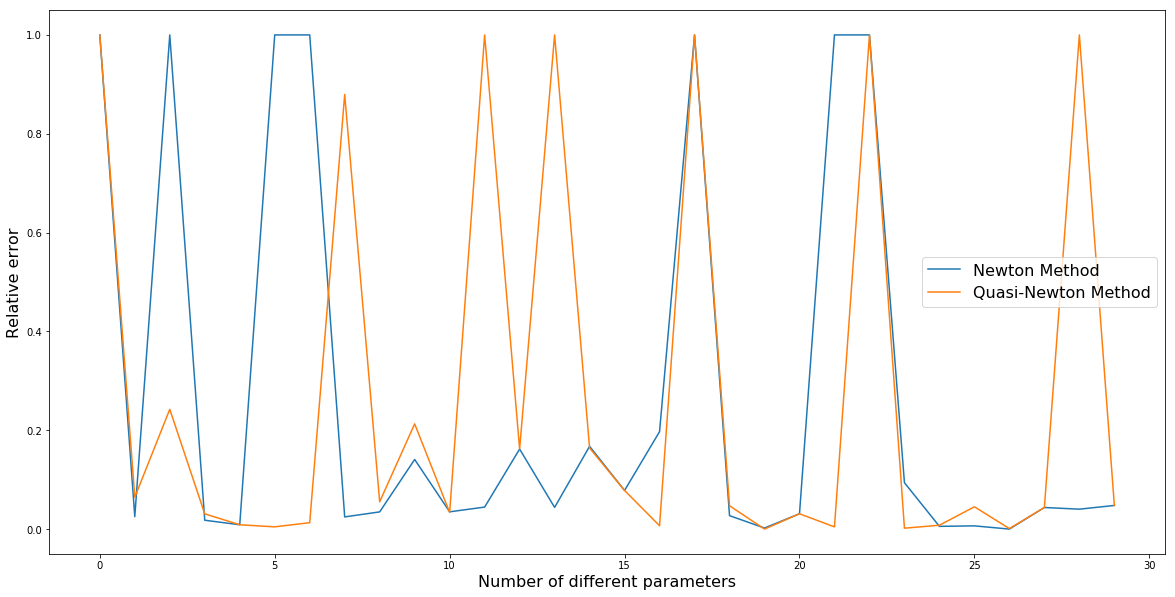

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(range(30), error_n, label="Newton Method")
plt.plot(range(30), error_qn, label="Quasi-Newton Method")
plt.xlabel("Number of different parameters", fontsize=16)
plt.ylabel("Relative error", fontsize=16)
plt.legend(fontsize=16)